# Download the Crisis Image Datasets

In [1]:
import os
import timeit
import shutil
from IPython.display import clear_output

# Remove the sample data to free up some spaces 
if os.path.isdir('sample_data'):
    shutil.rmtree('sample_data')

if not os.path.isdir('crisis_vision_benchmarks'):
    # get the tar gz file
    # https://www.youtube.com/watch?v=U-nsgM9XWtU&list=PLpoCVQU4m6j_jNSbNFBeyT-tchsbc3CLV&index=3
    t1 = timeit.default_timer()
    !wget --tries=30 https://crisisnlp.qcri.org/data/crisis_image_datasets_benchmarks/crisis_vision_benchmarks.tar.gz
    #!wget --continue --progress=dot:mega --tries=0 https://crisisnlp.qcri.org/data/crisis_image_datasets_benchmarks/crisis_vision_benchmarks.tar.gz
    t2 = timeit.default_timer()

    clear_output()
    print('Total time to download the dataset: {:.2f} min'.format((t2-t1) / 60))

In [2]:
if not os.path.isdir('crisis_vision_benchmarks'):
    # extract the tar gz file using previous tutorial
    t1 = timeit.default_timer()
    !tar --gunzip --extract --verbose --file=crisis_vision_benchmarks.tar.gz
    t2 = timeit.default_timer()

    clear_output()
    print('Total time to extract the dataset: {:.2f} min'.format((t2-t1) / 60))

    # remove the tar gz file to save space
    os.remove('crisis_vision_benchmarks.tar.gz')
    
    # remove additional dataset
    shutil.rmtree('crisis_vision_benchmarks/data/ASONAM17_Damage_Image_Dataset')
    shutil.rmtree('crisis_vision_benchmarks/data/aidr_info')

# Load all modules and Define the FLAGS
Main reference for the YOLOv3 model definition is: <br>
https://github.com/zzh8829/yolov3-tf2

In [3]:
import os
import sys 
import shutil
import time
import timeit
import json

import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import clear_output
import cv2

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Lambda
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau,
    EarlyStopping,
    ModelCheckpoint,
    TensorBoard
)


In [4]:
def show_image(input_var):
    if type(input_var) == str:
        img_path = os.path.join('crisis_vision_benchmarks/', input_var)
        img = plt.imread(img_path)
    else:
        img = input_var
    plt.imshow(img)
    plt.show()

In [5]:
devices = tf.config.list_physical_devices('GPU')
clear_output()

print("Tensorflow version " + tf.__version__)
print("Num GPUs Available: ", len(devices))

Tensorflow version 2.9.1
Num GPUs Available:  1


In [6]:
!nvidia-smi

Wed Oct  5 11:04:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   57C    P3    27W /  N/A |    330MiB /  7982MiB |     15%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Load the Dataset for Disaster Detection
Define a tf.data pipeline to load the dataset
- Get images and labels from Task (a) subset - Disaster Type
- Define the functions for (i) loading images and (ii) image augmentation
- The two functions will be used by tf.data pipeline to load and augment the images
- Create tf.data.dataset instance for **Training/Validation/Testing**

In [7]:
data_root = os.path.join(os.getcwd(), 'crisis_vision_benchmarks/')

annot_train_path = os.path.join(data_root, 'tasks/disaster_types/consolidated/consolidated_disaster_types_train_final.tsv')
annot_dev_path = os.path.join(data_root, 'tasks/disaster_types/consolidated/consolidated_disaster_types_dev_final.tsv')
annot_test_path = os.path.join(data_root, 'tasks/disaster_types/consolidated/consolidated_disaster_types_test_final.tsv')
    
# training data
print('TRAINING')
df = pd.read_csv(annot_train_path, sep='\t')
train_img_paths = df['image_path'].tolist()
train_labels = df['class_label'].tolist()

# overview on the balance of the dataset label
unique_labels = pd.unique(df['class_label'])
for unique_label in unique_labels:
    _ = df.loc[(df['class_label']==unique_label)]
    print(f'{unique_label}:', _.shape[0])

# dev data
print('\nVALIDATION')
df = pd.read_csv(annot_dev_path, sep='\t')
dev_img_paths = df['image_path'].tolist()
dev_labels = df['class_label'].tolist()

# test data
print('\nTEST')
df = pd.read_csv(annot_test_path, sep='\t')
test_img_paths = df['image_path'].tolist()
test_labels = df['class_label'].tolist()

# example
df.head()

TRAINING
hurricane: 1444
not_disaster: 3666
fire: 1270
flood: 2336
earthquake: 2058
other_disaster: 1132
landslide: 940

VALIDATION

TEST


,event_name,image_id,image_path,class_label
0,AIDR,1051850186446831618_0,data/aidr_disaster_types/hurricane_michael_201...,hurricane
1,AIDR,961262549005230080_2,data/aidr_disaster_types/natural_disaster/7_2_...,earthquake
2,AIDR,1037983665995706368_0,data/aidr_disaster_types/kerala_flood_2018/7_9...,flood
3,AIDR,597324321418149888_0,data/aidr_disaster_types/nepal_earthquake/10_5...,earthquake
4,AIDR,673228466414686208_0,data/aidr_disaster_types/chennai_flood/5_12_20...,not_disaster


In [8]:
def get_unique(alist):
    np_arr = np.array(alist)
    return np.unique(np_arr)

data_root = tf.convert_to_tensor(data_root, tf.string)
unique_label = get_unique(train_labels)

# training 
training_data = list(zip(train_img_paths, train_labels))
trainDS = tf.data.Dataset.from_tensor_slices(training_data)

# dev (validation)
data = list(zip(dev_img_paths, dev_labels))
valDS = tf.data.Dataset.from_tensor_slices(data)

# testing
data = list(zip(test_img_paths, test_labels))
testDS = tf.data.Dataset.from_tensor_slices(data)

2022-10-05 11:04:39.823048: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-05 11:04:39.823901: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 11:04:39.824634: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 11:04:39.825149: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [9]:
def load_data(data):
    # split the data into x and y (image and label)
    image_path = data[0]
    label = data[1]
    # read the image from disk, decode it, resize it
    image_path = tf.strings.join([data_root, image_path])
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224, 224)) # keep it as [0, 255] for mobilenet preprocess layers
    # encode the label
    label = tf.argmax(label == unique_label)
    # return the image and the integer encoded label
    return (image, label)

In [10]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomRotation(0.05),
        tf.keras.layers.RandomZoom(0.05),
    ]
)

@tf.function
def augment(image, label):
    '''
    MobileNetV2 Paper mentions that it is better to 
    train MobileNetV2 with less augmentation
    '''
    # perform random horizontal and vertical flips
    image = tf.image.random_flip_left_right(image)
    '''
    # extra
    #image = data_augmentation(image, training=True)
    # brightness
    image = tf.image.random_brightness(image, 0.2)
    # contrast
    image = tf.image.random_contrast(image, 0.8, 1.2)
    # saturation
    image = tf.image.random_saturation(image, 0.80, 1.20) #ori is 0.75-1.25
    '''
    # return the image and the label
    return (image, label)

In [11]:
# dont use cache to prevent ram overloaded
trainDS = (trainDS
    .shuffle(512) #.shuffle(len(training_data))
    .map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    .map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

valDS = (valDS
    .map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

testDS = (testDS
    .map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

Specification of element in this dataset
(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))

Extract a BATCH from the dataset
(64, 224, 224, 3)
(64,)


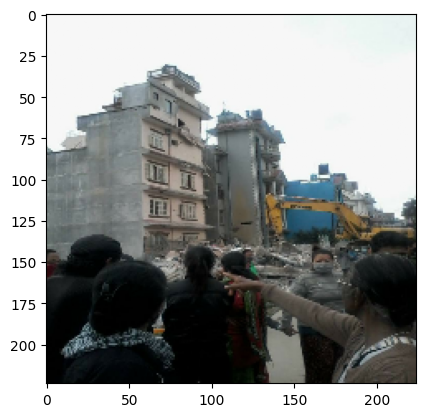

The label is 0, which means: earthquake
All labels: ['earthquake' 'fire' 'flood' 'hurricane' 'landslide' 'not_disaster'
 'other_disaster']


In [12]:
# get a BATCH of dataset for inspection
for element in trainDS.as_numpy_iterator():
    x, y = element
    break

clear_output()

# check specification of the element of this dataset
print('Specification of element in this dataset')
print(trainDS.element_spec)

# show the batch of images and labels
print('\nExtract a BATCH from the dataset')
print(x.shape)
print(y.shape)

# show example
if 'i' not in globals():
    i = 0
else:
    i +=1
show_image(x[i]/255)
print(f'The label is {y[i]}, which means: {unique_label[y[i]]}')
print(f'All labels: {unique_label}')

# Training: Disaster Detection

In [13]:
##############################################################################
# MODEL
##############################################################################
def get_mobilenetv2():
    # pretrained model
    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                                   include_top=False,
                                                   weights='imagenet')
    # Fine-tune from this layer onwards
    fine_tune_at = 50
    base_model.trainable=True
    for layer in base_model.layers[:fine_tune_at]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False
    
    # create the global model
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = preprocess_input(inputs)
    x = base_model(x) #x = base_model(x, training=False)
    
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Reshape((1, 1, 1280))(x)
    x = tf.keras.layers.Dropout(0.3, name='Dropout')(x)
    x = tf.keras.layers.Conv2D(7, (1, 1), padding='same')(x)
    x = tf.keras.layers.Activation('softmax', name='softmax')(x)
    outputs = tf.keras.layers.Reshape((7,))(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

disaster_predictor = get_mobilenetv2()
disaster_predictor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [14]:
disaster_predictor = get_mobilenetv2()

EPOCH = 150
opt = tf.keras.optimizers.Adam(
    learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, #1e-4
    name='Adam'
)

disaster_predictor.compile(optimizer=opt,
                           loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

history = disaster_predictor.fit(
    x = trainDS,
    validation_data=valDS,
    epochs = EPOCH,
    callbacks = ReduceLROnPlateau(patience=10, verbose=0)
)

In [15]:
# Evaluate the model on test dataset
test_pred = disaster_predictor.predict(testDS)
test_pred = tf.math.argmax(test_pred, axis=1)

test_label = []
for img_, label_ in testDS:
    # label_ = tf.math.argmax(label_, axis=1)
    test_label = tf.concat([test_label, label_], 0)

from sklearn import metrics
acc = metrics.accuracy_score(test_pred, test_label)
prec, recall, f1, _ = metrics.precision_recall_fscore_support(test_pred, test_label, average='weighted')
clear_output()

print("\nScore:")
print("accuracy: {:.3f} - precision: {:.3f} - recall: {:.3f} - f1_score: {:.3f}".format(acc, prec, recall, f1))


Score:
accuracy: 0.776 - precision: 0.787 - recall: 0.776 - f1_score: 0.781


In [16]:
# uncomment to save model weights
# disaster_predictor.save('mobilenet_disaster.h5')